# Overview
This notebook demonstrates the steps to load Facebook friends' online activity data stored in a sample JSON file, perform required pre-processing,
and generate different plots.

# Import Libraries

In [1]:
import json
import pendulum
from itertools import groupby
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np

# Load the data

In [7]:
with open("./online_friends.json", "r") as f:
    data = json.load(f)

# Get the list of friend names
friends = set()
for record in data:
    friends = friends.union(set(record["friends"]))
friends = list(friends)

# Create a dictionary of friend_name -> timestamps when online    
timestamps = {name: [] for name in friends}
for record in data:
    online_friends = record["friends"]
    ts = record["timestamp"]
    
    for name in online_friends:
        # Convert timestamp to pendulum date and append to friend's list  
        timestamps[name].append(pendulum.parse(ts))

# Pre-process

In [3]:
def groupby_day(timestamps):
    """
    Groups list of timestamps for a friend by day of the month and returns
    an Ordered dictionary of days -> timestamps when online in chronological
    order.
    
    Parameters
    ----------
    timestamps : list
        List of timestamps when the user was found online
        
    Returns
    -------
    OrderedDict
        Dictionary in chronological order, with list of timestampes grouped by each day
        
    """
    # Group timestamps by the day of month
    groups = groupby(timestamps, lambda d: d.format('dd DD/MM/YY'))
    groups = {key: list(value) for key, value in groups}

    # Sort timestamps for each day
    date_keys = sorted([pendulum.from_format(key, 'dd DD/MM/YY') for key in groups.keys()])
    sorted_keys = [dk.format('dd DD/MM/YY') for dk in date_keys]

    return OrderedDict([(key, groups[key]) for key in sorted_keys])


# Create nested dictionary of friend -> (day of month -> timestamps)
# telling when each friend was online over different times of the day
activities = OrderedDict()
for friend, tsz in timestamps.items():
    data = groupby_day(tsz)
    activities[friend] = data
    
print("Friends: ", list(activities.keys()))
print("Days: ", list(activities[friends[0]].keys()))

Friends:  ['Jane Roe', 'Jane Doe', 'John Roe', 'John Doe']
Days:  ['We 15/05/19', 'Th 16/05/19']


In [4]:
def digitize_day(dates):
    """
    Given a list of timestamps for a single day, creates a binary map
    representing when user was online at a particular time of the day
    at intervals of 5 minutes.

    Parameters
    ----------
    dates : list
        List of pendulum.datetime objects for any particular day, representing
        times when user was online.

    Returns
    -------
    list
        list of binary values of size 288 = 24h*60m / 5min representing when user 
        was online in intervals of 5 min (1 indicates being online and 0 indicated offline).
    list
        list of bins of size 288 = 24h*60m / 5min representing the intervals in 
        the day.
    """

    # Get hour and minute from date objects
    day_tz = list(map(lambda d: ( int(d.format('HH')), int(d.format('mm')) ), data))

    # Create linear space from 0-24h*60m with a gap of 5 min
    bins = np.arange(0, 24*60+5, 5)  # len = 289

    # Get absolute time of the day when user was online in minutes
    active = [t[0]*60 + t[1] for t in day_tz]

    # Get indices of the bins to which each value in active belongs
    active_bin_ind = np.digitize(active, bins)
    
    # Get unique indices (there can be duplicates within each 5 min interval)
    active_bin_ind = list(set(active_bin_ind))

    # Create binary map, 1 representing when user was online over the day 
    # and 0 representing offline.
    y = np.zeros((len(bins)))
    y[active_bin_ind] = 1

    return y, bins  # return activity map and bin intervals

# Create online activity map for each friend
online_maps = []
for friend, activity in activities.items():
    friend_online_map = []
    for day, data in activity.items():
        y, bins = digitize_day(data)
        friend_online_map.append(y)
    
    online_maps.append(friend_online_map)

# Get the list of all days
days = list(activities[next(iter(activities))].keys())

# online_maps is a numpy array of shape (no. of friends, no. of days, no. of bins i.e 289)
online_maps = np.array(online_maps)
print(online_maps.shape)

(4, 2, 289)


# Plot active status

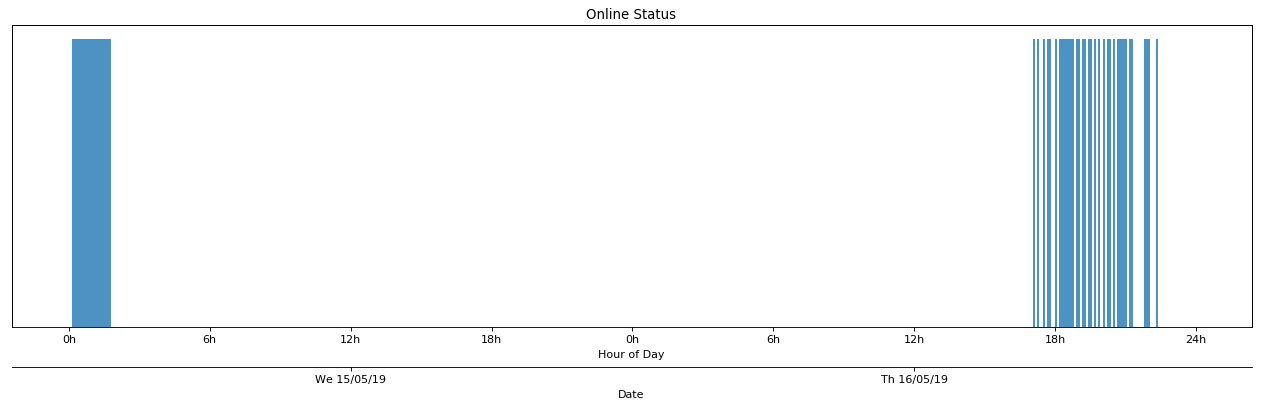

In [5]:
num_days = len(days)

# Get activity map of first friend
y = online_maps[0, :, :].flatten() 

# Setup figure
plt.figure(num=None, figsize=(20, 5), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot(1,1,1)

# No. of ticks for each day on x axis
num_x_ticks = 4

# Plot
ax1.bar(np.arange(len(y)), y, alpha=0.8, align='center', width=1)

# Setup first x axis ticks (shows hours of the day)
x_ticks = []
for i in range(num_days):
    # +1 in 24+1 allows last point to be inclusive for last day
    start, end = 0, 24+1 if i == num_days-1 else 24 
    x_ticks.extend([str(i)+"h" for i in np.arange(start, end, 24/num_x_ticks, dtype=np.uint8)])

x_ticks_pos = np.arange(0, len(y)+1, len(y)/num_days/num_x_ticks)
ax1.set_xticks(x_ticks_pos)
ax1.set_xticklabels(x_ticks)
ax1.set_xlabel('Hour of Day')

# Setup second x axis ticks (shows Date)
ax2 = ax1.twiny()
newpos = np.arange(len(y)/num_days/2, len(y), len(y)/num_days)
ax2.set_xticks(newpos)
ax2.set_xticklabels(days)

ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Date')
ax2.set_xlim(ax1.get_xlim());

# Remove y ticks
plt.yticks([])
# Setup title
plt.title('Online Status');

# Plot no. of online friends over the day

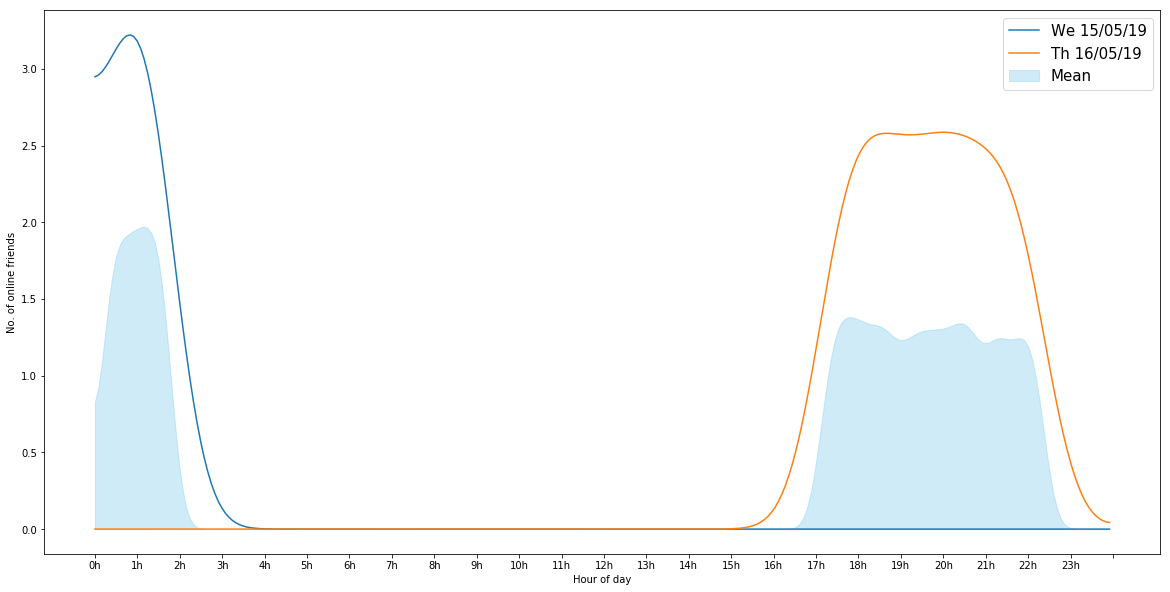

In [6]:
def gaussian_smooth(y, sigma=3):
    """
    Applies Guassian filtering to a 1D list of integers.
    
    """
    
    from scipy.ndimage.filters import gaussian_filter1d

    ysmoothed = gaussian_filter1d(y, sigma=sigma)
    return ysmoothed
    

# Sum over the activity map for each friend to get online count
online_count = np.sum(online_maps, axis=0)

# Generate x axis points
x = np.arange(online_count.shape[-1])

# Create figure
fig = plt.figure()
ax = plt.subplot(1,1,1)
fig.set_figwidth(20)
fig.set_figheight(10)

# Plot
for day, y in zip(*(days, online_count)):
    y = gaussian_smooth(y, sigma=8)

    ax.plot(x, y, label=day)

# Setup x-axis ticks
ax.set_xticks(np.arange(0, len(y)+1, len(y)/24))  # +1 in len(y)+1 allows last point to be inclusive
ax.set_xticklabels([str(i)+"h" for i in np.arange(0, 24)])

ax.set_ylabel('No. of online friends')
ax.set_xlabel('Hour of day')
    
# Get mean of online count
y_mean = np.mean(online_count, axis=0)
y_mean = gaussian_smooth(y_mean)

# Plot mean online count as area graph
ax.fill_between(x, y_mean, color="skyblue", alpha=0.4, label='Mean')

# Set legend
ax.legend(loc='upper right', prop={'size': 15})